# Superoperator Method

This notebook implements and tests some of the superoperator formalism.

In [1]:
from transmon_code.superoperators import *
from transmon_code.helpers import *
from qutip import *
from transmon_code.simulate import *
from transmon_code.transmon import Transmon
import numpy as np
import pickle

In [2]:
# setup the transmon
tr = Transmon(n_levels=8, initial_state=0, Ω=5000, α=-100, RWA=True, dt=1/1000)
tr.X90_args = {'A': 7.449877548484732, 'Γ': 0.5024320350942441, 'ω': tr.Ω, 'A_DRAG': -0.0034947574297965116}

# set up the idealised PTM

PTM = PTMs(tr.n_levels)
X90_PTM_ideal = PTM.ideal_PTM("X90")

In [ ]:
# learn the X90 PTM

X90_PTM = PTM.learn_X90_PTM(tr)

In [ ]:
# save everything
with open("transmon_PTMs", "wb") as f:
    pickle.dump([tr, X90_PTM], f)

In [3]:
# load everything
with open("transmon_PTMs", "rb") as f:
    tr, X90_PTM = pickle.load(f)

In [11]:
# check that the PTM gives the same result as the pulse
%matplotlib qt

res_sim = simulate(tr, tr.X90_args)
res_PTM = PTM.apply_PTM(X90_PTM, tr.ψ0)
res_PTM_ideal = PTM.apply_PTM(X90_PTM_ideal, tr.ψ0)

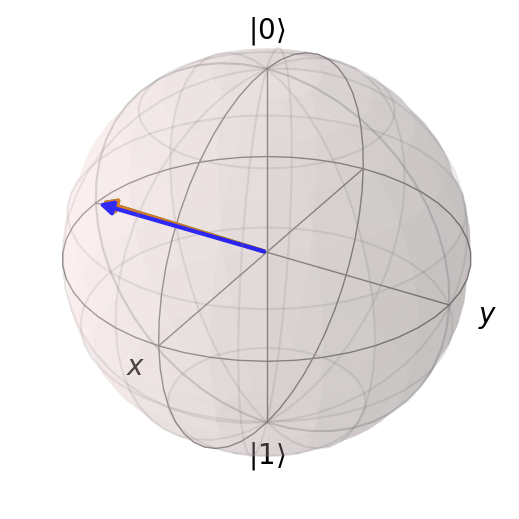

1.0000009328827828
0.9999999999999999 1.0000000012381398


In [15]:
plot_bloch([res_sim[-1], res_PTM, res_PTM_ideal])
print(fidelity(res_sim[-1], res_PTM))
print(res_sim[-1].norm(), res_PTM.norm())

In [16]:
average_gate_fidelity(X90_PTM, X90_PTM_ideal)

0.019227635023357826

Performing simulation...
Calculating via PTMs...


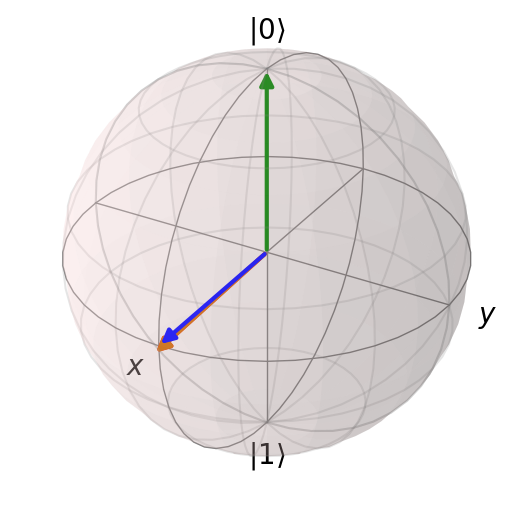

In [6]:
# check a single gate runs as expected

gate = "Y90"
g = U(gate_angles[gate])

# via simulation
print("Performing simulation...")
res_sim, _ = simulate_circuit(tr, g, plot=False)

# via ideal PTM
print("Calculating via PTMs...")
gate_PTM = PTM.ideal_PTM(gate)
res_PTM1 = PTM.apply_PTM(gate_PTM, tr.ψ0)

# via decomposition
circ_PTM = PTM.circuit_PTM(gate, X90_PTM)
res_PTMc = PTM.apply_PTM(circ_PTM, tr.ψ0)

plot_bloch([tr.ψ0, res_sim, res_PTM1, res_PTMc])

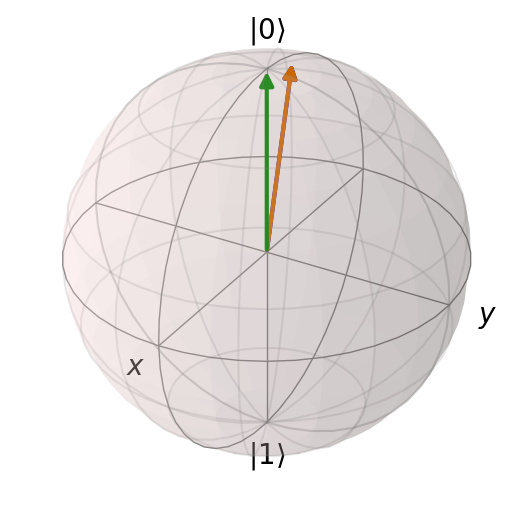

In [7]:
# check a circuit works as expected

circ = ["X90", "Z90", "Y90", "X180"]

# via pulse simulation
res_sim, _ = simulate_circuit(tr, circ, plot=False)

# via circuit decomposition
circ_PTM = PTM.circuit_PTM(circ, X90_PTM)
res_PTM = PTM.apply_PTM(circ_PTM, tr.ψ0)

plot_bloch(truncate([tr.ψ0, res_sim, res_PTM]))

In [8]:
fidelity(res_sim, res_PTM)

0.9999620806297129

In [ ]:
# calculate the error gate
error_gate = X90_PTM * PTM.ideal_PTM("X270")#.inv()
Qobj(np.eye(error_gate.dims[0][0])) - error_gate

In [ ]:
# perform RBT
lengths = [20]

f = PTM.RBT_PTM(tr, X90_PTM, lengths, 1)